In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
from diffusers import StableDiffusionPipeline

# Load Stable Diffusion model pretrained


In [3]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


In [4]:
print(pipe)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Modèle de génération d'image
diffusion_model = pipe.unet.to(device)

# Modèle Tokenizer (tokeniser le text)
tokenizer = pipe.tokenizer

# Modèle text encoder (créer embedding)
text_encoder = pipe.text_encoder.to(device)

# L'encodeur/décodeur variationnel (VAE) utilisé pour transformer l'image en un espace latent
vae = pipe.vae.to(device)

# Le Scheduler (gère les étapes de bruitage/débruitage)
scheduler = pipe.scheduler

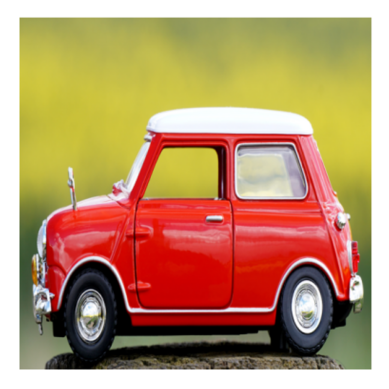

In [7]:
# load image in example/car.jpg and plot it

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

image_path = "Voiture_Genia.png"
image = Image.open(image_path).convert("RGB")
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
image = image.to(diffusion_model.device)

# Etape 1 : Find eopt


In [8]:
prompt = "A yellow car"
device = "cuda"

timesteps = 1
alpha_t = 0.5

In [9]:
# This function is the first step (A) Optimize embedding and find eopt
def optimize_embeddings(input_image, target_text, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=1000):

  tokens = tokenizer(target_text, padding="max_length", truncation=True, return_tensors="pt")
  prompt_tokens = tokens.input_ids.to(device)


  # freeze embedding model parameters
  with torch.no_grad():
      etgt = text_encoder(prompt_tokens).last_hidden_state


  # Ici on initialise eopt (l'embedding a optimiser)
  eopt = etgt.clone().detach().requires_grad_(True)

  optimizer = optim.Adam([eopt], lr=2e-3)
  criterion = nn.MSELoss()


  # freeze diffusion model parameters
  for param in diffusion_model.parameters():
      param.requires_grad = False

  image = input_image.clone()

  # Permet de normaliser l'image (peut-être pas nécessaire)
  image_m1_1 = (image.to(device) * 2.0) - 1.0

  with torch.no_grad():
      image_latent = vae.encode(image_m1_1).latent_dist
      image_latent = image_latent.mean * vae.config.scaling_factor
      image_latent.to(device)


  for i in range(nb_step):
      print("step " , i)
      noise_latent = torch.randn_like(image_latent)

      t = torch.randint(1, 50, size=(1,)).to(device)

      # Le scheduler permet d'ajouter du bruit t
      image_latent_noise = scheduler.add_noise(image_latent, noise_latent, t)

      # .sample permet de récupérer spécifiquement le tensor
      output = diffusion_model(image_latent_noise, t, encoder_hidden_states=eopt)
      noise_pred = output.sample

      noise_latent = scheduler.scale_model_input(noise_latent, t)

      # update embeddings
      optimizer.zero_grad()
      loss = criterion(noise_pred, noise_latent)
      loss.backward()
      optimizer.step()

  return (etgt, eopt)


etgt, eopt = optimize_embeddings(image, prompt, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=100)



step  0
step  1
step  2
step  3
step  4
step  5
step  6
step  7
step  8
step  9
step  10
step  11
step  12
step  13
step  14
step  15
step  16
step  17
step  18
step  19
step  20
step  21
step  22
step  23
step  24
step  25
step  26
step  27
step  28
step  29
step  30
step  31
step  32
step  33
step  34
step  35
step  36
step  37
step  38
step  39
step  40
step  41
step  42
step  43
step  44
step  45
step  46
step  47
step  48
step  49
step  50
step  51
step  52
step  53
step  54
step  55
step  56
step  57
step  58
step  59
step  60
step  61
step  62
step  63
step  64
step  65
step  66
step  67
step  68
step  69
step  70
step  71
step  72
step  73
step  74
step  75
step  76
step  77
step  78
step  79
step  80
step  81
step  82
step  83
step  84
step  85
step  86
step  87
step  88
step  89
step  90
step  91
step  92
step  93
step  94
step  95
step  96
step  97
step  98
step  99


In [13]:
print(etgt)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.9568, -0.3391, -0.3438,  ...,  1.6478, -0.9793,  0.8329],
         ...,
         [ 0.8534, -0.2147, -0.9066,  ...,  0.0736,  0.3958, -0.4212],
         [ 0.8670, -0.2368, -0.8705,  ...,  0.0706,  0.3949, -0.3897],
         [ 0.8155, -0.1587, -0.8455,  ...,  0.0757,  0.4136, -0.4125]]],
       device='cuda:0')


In [14]:
print(eopt)

tensor([[[-0.4757,  0.0324, -0.0516,  ..., -0.3816, -0.4362,  0.0938],
         [ 0.0602, -1.3897,  0.3945,  ..., -0.3820,  1.1054,  0.7263],
         [ 1.0113, -0.3907, -0.2490,  ...,  1.6379, -0.9805,  0.8289],
         ...,
         [ 0.7730, -0.1193, -0.8895,  ...,  0.1476,  0.3706, -0.4637],
         [ 0.7882, -0.1442, -0.8543,  ...,  0.1440,  0.3687, -0.4303],
         [ 0.7329, -0.0647, -0.8306,  ...,  0.1491,  0.3866, -0.4596]]],
       device='cuda:0', requires_grad=True)


# Etape 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


def finetune_unet(
    input_image_0_1, # Image originale (tenseur 0-1)
    eopt,            
    unet,
    vae,             # Le VAE (pour encoder l'image)
    scheduler,       # Le scheduler (pour bruiter)
    device,
    num_steps=1500,
    lr=5e-7
):

    unet.train() # Met le modèle en mode entraînement
    for param in unet.parameters():
        param.requires_grad = True # S'assurer que les gradients sont activés


    # Optimizer pour Unet
    optimizer = optim.AdamW(unet.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Même chose que pour eopt
    image_m1_1 = (input_image_0_1.to(device) * 2.0) - 1.0

    # Pas besoin de modifier vae
    with torch.no_grad():
        encoded_dist = vae.encode(image_m1_1).latent_dist
        z0 = encoded_dist.mean * vae.config.scaling_factor
        
        
    # --- Boucle de Fine-tuning ---
    progress_bar = tqdm(range(num_steps))
    for step in range(num_steps):
        print("step = ", step)
        optimizer.zero_grad()

        noise_latent = torch.randn_like(z0, device=device)
        t = torch.randint(0, scheduler.config.num_train_timesteps, (1,), device=device).long()

        zt = scheduler.add_noise(z0, noise_latent, t)
        output = unet(zt, t, encoder_hidden_states=eopt)
        noise_pred = output.sample

        # Calculate loss
        loss = criterion(noise_pred, noise_latent)

        # Backpropagate
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
        progress_bar.set_postfix({"Loss": loss.item()})

    return unet




unet_fine_tuned = finetune_unet(
    image,
    eopt, # L'output de optimize_embeddings
    diffusion_model,
    vae,
    scheduler,
    device,
    num_steps=1500,
    lr=5e-7
)


Encoding image for fine-tuning...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 12.68 GiB is allocated by PyTorch, and 149.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Etape 3

In [13]:

def interpolate_embeddings(etgt, eopt, eta):

  e_interpolated = eta * etgt + (1 - eta) * eopt

  return e_interpolated

interpolation_factor_eta = 0.7
e_interpolated = interpolate_embeddings(etgt, eopt, eta=interpolation_factor_eta)


# Script permettant d'observer la prédiction du modèle avec etbt après optimisation  

##  (A utiliser uniquement pour le rapport)

Starting denoising loop...


100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


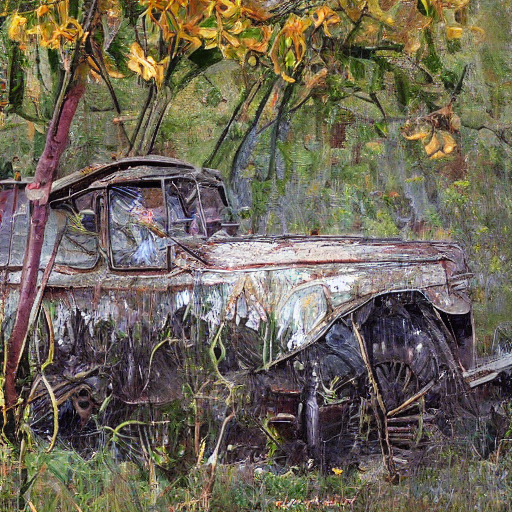

In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(input_image, eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50):

    image_m1_1 = (input_image * 2.0) - 1.0

    with torch.no_grad():
        image_latent = vae.encode(image_m1_1).latent_dist
        latents = image_latent.mean * vae.config.scaling_factor
        latents.to(device)

    # Génération a partir de bruit
    latents = torch.randn_like(latents)

    # 3. Définir les timesteps
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)


    # Boucle pour enlever le bruit
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        latent_model_input = scheduler.scale_model_input(latents, t) # Mise à l'échelle si besoin

        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    # Passer de l'espace latent à l'image réelle
    latents = latents / vae.config.scaling_factor
    image_pixels = vae.decode(latents).sample

    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # Remap [-1, 1] -> [0, 1]
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # Format [Batch, H, W, C] pour PIL
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # Prend la 1ere image du batch

    return image_pil


generate_with_eopt(image, e_interpolated, unet_fine_tuned, scheduler, vae, device="cuda", height=512, width=512, num_inference_steps=50)

# Test


In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, seed=None): # Removed input_image from args
    """Génère une image en utilisant l'embedding optimisé eopt, en partant de bruit."""

    # --- Initial Setup ---
    if seed is not None:
        generator = torch.Generator(device=device).manual_seed(seed)
    else:
        generator = None

    unet = unet.to(device).eval()
    vae = vae.to(device).eval()
    eopt = eopt.to(device)

    # --- 1. Initialisation du Bruit Latent ---
    # PAS d'encodage de l'image d'entrée ici.
    # image_m1_1 = (input_image * 2.0) - 1.0 # ERREUR : Supprimé
    # with torch.no_grad(): # ERREUR : Supprimé
    #     image_latent = vae.encode(image_m1_1).latent_dist # ERREUR : Supprimé
    #     latents = image_latent.mean * vae.config.scaling_factor # ERREUR : Supprimé
    #     latents.to(device) # ERREUR : Supprimé

    # CORRECTION : Créer bruit aléatoire
    latent_height = height // 8
    latent_width = width // 8
    latent_channels = unet.config.in_channels
    latent_shape = (1, latent_channels, latent_height, latent_width)
    latents = torch.randn(latent_shape, generator=generator, device=device, dtype=unet.dtype)
    print(f"Initial random latents shape: {latents.shape}, Device: {latents.device}")


    # --- 2. Préparer le Scheduler ---
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device) # OK

    # Mise à l'échelle initiale du bruit (important !)
    latents = latents * scheduler.init_noise_sigma # OK


    # --- ERREUR : Ligne ajoutée incorrecte ---
    # noise_latent = torch.randn_like(latents) # ERREUR : Bruit redondant
    # latents = diffusion_model(noise_latent, timesteps, encoder_hidden_states=eopt).to(device) # ERREUR : Conceptuellement faux
    # Cette ligne essayait d'appeler le modèle sur du bruit pur avec *tous* les timesteps en même temps ?
    # Elle court-circuitait complètement la boucle de débruitage itératif. Supprimée.


    # --- 3. Boucle de Débruitage ---
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        # Pas de guidance nécessaire ici
        latent_model_input = scheduler.scale_model_input(latents, t) # OK (Mise à l'échelle si besoin)

        # Prédire le bruit avec le UNet
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample # OK

        # Calculer l'état précédent avec le scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample # OK
    print("Denoising finished.")


    # --- 4. Décoder l'Image Latente Finale ---
    latents = latents / vae.config.scaling_factor # OK
    print("Decoding final latents...")
    image_pixels = vae.decode(latents).sample # OK

    # --- 5. Post-traitement ---
    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # OK
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # OK
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # OK

    return image_pil


# --- Appel ---
# Assurez-vous que 'eopt' est l'embedding optimisé et DÉTACHÉ
# Assurez-vous que 'unet' (diffusion_model dans l'appel original), 'scheduler', 'vae' sont chargés
# Assurez-vous que 'device' est défini

# image_result = generate_with_eopt(eopt, unet, scheduler, vae, device, num_inference_steps=50, seed=42)
# image_result.show()

# Example generation Text-Image



In [15]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "An astronaut riding horse in Mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")


100%|██████████| 50/50 [11:36<00:00, 13.93s/it]  
